In [1]:
%cd /content/
!rm -rf convnet2
# Clonamos el repositorio
!git clone https://github.com/alvaro-neira/convnet2.git 

/content
Cloning into 'convnet2'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 363 (delta 231), reused 210 (delta 103), pack-reused 0
Receiving objects: 100% (363/363), 214.64 KiB | 6.50 MiB/s, done.
Resolving deltas: 100% (231/231), done.


## Preparación de los datos

In [2]:
# Crear directorios para datos y snapshots
!mkdir -p /content/convnet2/snapshots
!mkdir -p /content/convnet2/logs
!mkdir -p /content/convnet2/data

!ls convnet2

configs   models	      ssearch.py	     train_siamese.py
data	  README.md	      ssearch_with_merge.py  train_simple.py
datasets  release_siamese.py  test_tfrecords.py      utils
logs	  snapshots	      train.py


In [3]:
# Descargar y descomprimir los datos
%cd /content/convnet2/data
!wget https://www.dropbox.com/sh/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa -O data.zip
!unzip -q -o data.zip
!unzip -q -o train_images.zip
!unzip -q -o test_images.zip
!rm data.zip
!rm train_images.zip
!rm test_images.zip
!ls

/content/convnet2/data
--2021-11-13 23:14:04--  https://www.dropbox.com/sh/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa [following]
--2021-11-13 23:14:04--  https://www.dropbox.com/sh/raw/hsqjv0kd13xda3g/AABYkVk0ruG85s4aL4C1nDKaa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb514fcbbfd36d5cfc06c95d141.dl.dropboxusercontent.com/zip_download_get/A9Vwvv4H3LHhIh3E85Fi6NCxLlr5Ouky5UhkjZbOygFTg4gpnz5L6nowiGve7-TocnvfgE7dnXUExM3MC-dlJDNUCbHNdetjbM4xrOCOBoYaJA# [following]
--2021-11-13 23:14:05--  https://ucb514fcbbfd36d5cfc06c95d141.dl.dropboxusercontent.com/zip_download_get/A9Vwvv4H3LHhIh3E85Fi6NCxLlr5Ouky5UhkjZbOygFTg4gpnz5L6nowiGve7-

## Predicciones

A continuación, veremos algunas predicciones de ejemplo utilizando los pesos aprendidos por este último modelo. Para esto, copiaremos el último checkpoint desde Google Drive a la sesión de Colab (si no se ha cerrado la sesión desde el entrenamiento, este paso no será necesario). Podemos acceder al contenido de nuestro Drive con el botón "Activar unidad de Drive" en el menú de la izquierda.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


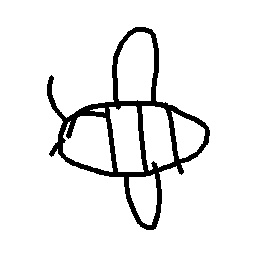

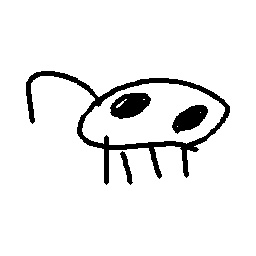

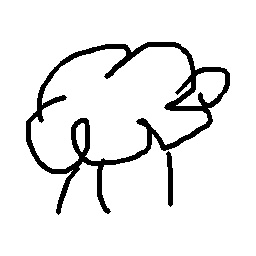

In [5]:
from IPython.display import Image, display

display(Image('/content/convnet2/data/test_images/bee/026_00119695.jpg', width=200, height=200))
display(Image('/content/convnet2/data/test_images/cow/081_00122082.jpg', width=200, height=200))
display(Image('/content/convnet2/data/test_images/sheep/258_00124921.jpg', width=200, height=200))

In [9]:
%cd /content/convnet2
!git fetch --all
!git checkout resnet34_prediction
!git pull origin resnet34_prediction
!cp /content/drive/MyDrive/tarea1/shape.dat /content/convnet2/data/shape.dat
!cp /content/drive/MyDrive/tarea1/mean.dat /content/convnet2/data/mean.dat
!python train_simple.py -mode predict -config configs/aneira_tfr.config -name SKETCH # no delay


/content/convnet2
Fetching origin
Already on 'resnet34_prediction'
Your branch is up to date with 'origin/resnet34_prediction'.
From https://github.com/alvaro-neira/convnet2
 * branch            resnet34_prediction -> FETCH_HEAD
Already up to date.
2021-11-13 23:21:31.256065: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (ResNetBackbone)   multiple                  21298112  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 classifier (Dense)          multiple                 

## Búsqueda por similitud

Finalmente, usaremos la salida de la última capa convolucional de ResNet-34 (con un global average pooling) para realizar una búsqueda por similitud. Utilizaremos el archivo ```/content/convnet2/ssearch.py```. El primer paso es preparar un directorio y un catálogo:

In [10]:
!mkdir -p /content/convnet2/data/sketch_folder
%cd /content/convnet2/data/sketch_folder

# Crear directorio para la búsqueda por similitud
!mkdir -p ssearch
!cp /content/convnet2/data/test.txt .
# Eliminar la columna de clasificación del archivo test.txt
!awk 'NF{NF-=1};1' <test.txt >catalog.txt
!mv catalog.txt ssearch/
!cat ssearch/catalog.txt

/content/convnet2/data/sketch_folder
cp: cannot stat '/content/convnet2/data/test.txt': No such file or directory
/bin/bash: test.txt: No such file or directory
mv: cannot stat 'catalog.txt': No such file or directory
cat: ssearch/catalog.txt: No such file or directory


In [13]:
# Calculamos los feature vectors ~1 minuto
%cd /content/convnet2/
!git fetch --all
!git checkout ssearch
!git pull origin ssearch
!cp data/shape.dat data/sketch_folder/shape.dat
!cp data/mean.dat data/sketch_folder/mean.dat
!cp /content/drive/MyDrive/tarea1/catalog.txt /content/convnet2/data/sketch_folder/ssearch/catalog.txt
!python ssearch.py -config configs/aneira_tfr.config -name SKETCH -mode compute

/content/convnet2
Fetching origin
Already on 'ssearch'
Your branch is up to date with 'origin/ssearch'.
From https://github.com/alvaro-neira/convnet2
 * branch            ssearch    -> FETCH_HEAD
Already up to date.
2021-11-13 23:25:35.323525: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (ResNetBackbone)   multiple                  21298112  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 classifier (Dense)          multiple                  0 (unused)
                     

In [18]:
# Hacemos la búsqueda por similitud 
!python ssearch.py -config configs/aneira_tfr.config -name SKETCH -mode search

2021-11-13 23:30:43.227015: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (ResNetBackbone)   multiple                  21298112  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 classifier (Dense)          multiple                  0 (unused)
                                                                 
Total params: 21,298,112
Trainable params: 21,282,880
Non-trainable params: 15,232
_________________________________________________________________
sim_model was loaded O

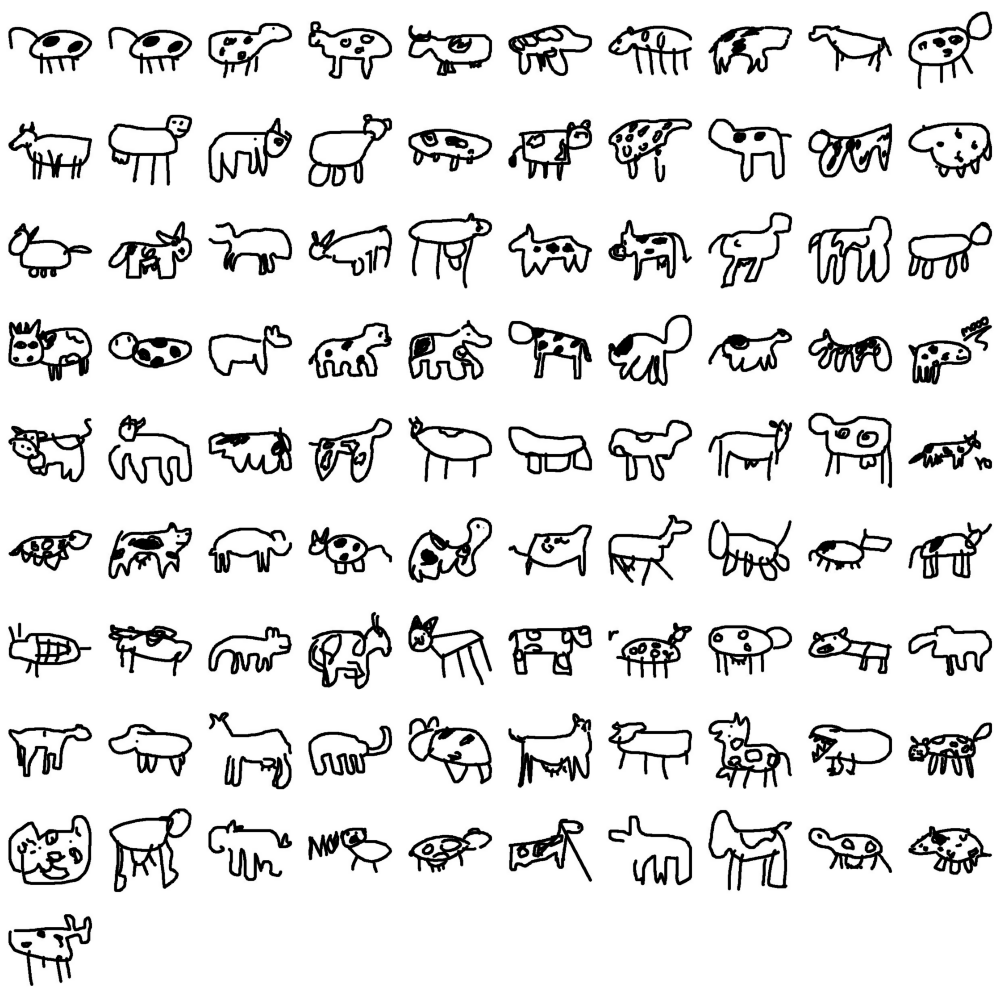

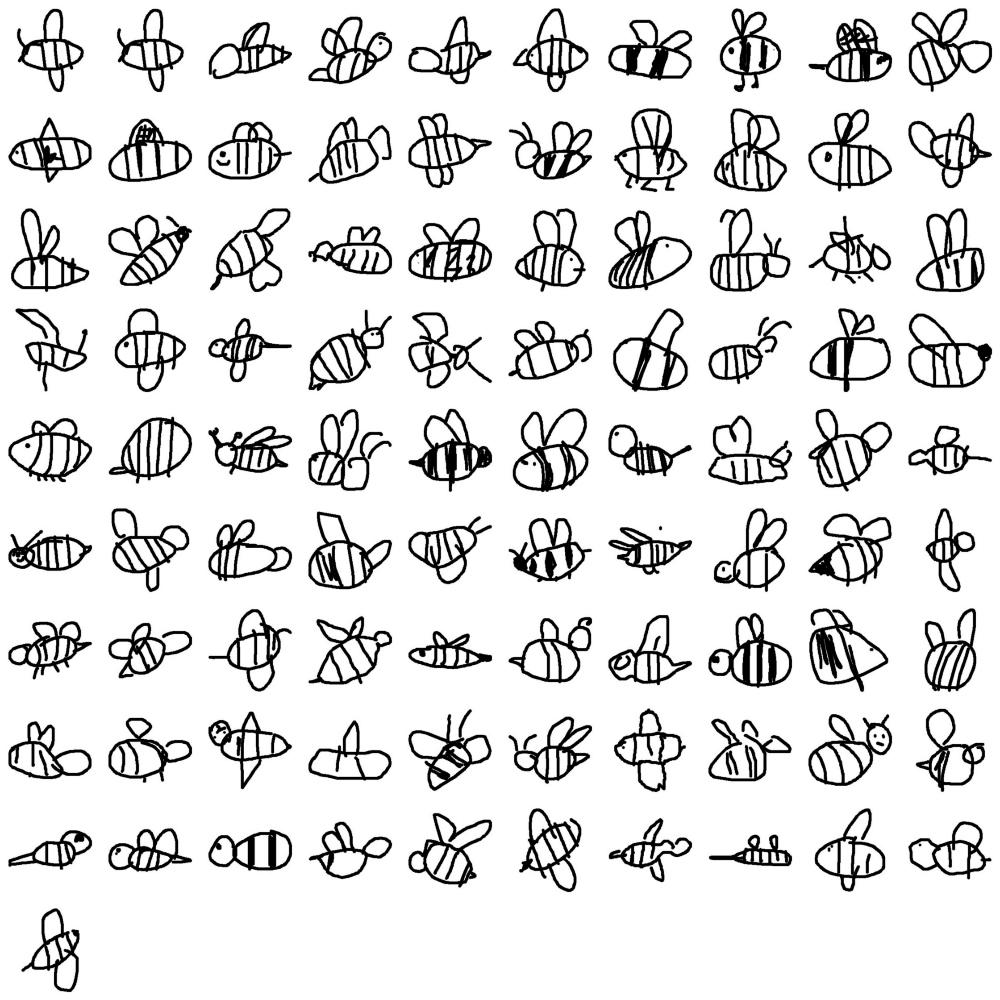

In [ ]:
display(Image('/content/convnet2/081_00122082.jpg_result.png', width=800, height=800))
display(Image('/content/convnet2/026_00119695.jpg_result.png', width=800, height=800))
